# 项目简介

赛题以预测二手车的交易价格为任务
数据来自某交易平台的二手车交易记录，总数据量超过40W
包含31列变量信息，其中15列为匿名变量。为了保证比赛的公平性，
将会从中抽取15万条作为训练集，5万条作为测试集A，5万条作为测试集B，
同时会对name、model、brand和regionCode等信息进行脱敏。

In [227]:
# Field				Description
# SaleID				交易ID，唯一编码
# name				汽车交易名称，已脱敏
# regDate				汽车注册日期，例如20160101，2016年01月01日
# model				车型编码，已脱敏
# brand				汽车品牌，已脱敏
# bodyType			车身类型：豪华轿车：0，微型车：1，厢型车：2，大巴车：3，敞篷车：4，双门汽车：5，商务车：6，搅拌车：7
# fuelType			燃油类型：汽油：0，柴油：1，液化石油气：2，天然气：3，混合动力：4，其他：5，电动：6
# gearbox	 			变速箱：手动：0，自动：1
# power	 			发动机功率：范围 [ 0, 600 ]
# kilometer			汽车已行驶公里，单位万km
# notRepairedDamage	汽车有尚未修复的损坏：是：0，否：1
# regionCode			地区编码，已脱敏
# seller				销售方：个体：0，非个体：1
# offerType			报价类型：提供：0，请求：1
# creatDate			汽车上线时间，即开始售卖时间
# price				二手车交易价格（预测目标）
# v系列特征	匿名特征，包含v0-14在内15个匿名特征

# 导入函数工具箱

In [228]:
## 基础工具
import numpy as np
import pandas as pd
import warnings
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import jn
from IPython.display import display, clear_output
import time

warnings.filterwarnings('ignore')
%matplotlib inline

## 模型预测的
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor

## 数据降维处理的
from sklearn.decomposition import PCA,FastICA,FactorAnalysis,SparsePCA

import lightgbm as lgb
import xgboost as xgb

## 参数搜索和评价的
from sklearn.model_selection import GridSearchCV,cross_val_score,StratifiedKFold,train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

import missingno as msno

# 数据读取

In [229]:
## 通过Pandas对于数据进行读取 
train_data = pd.read_csv('./used_car_train_20200313.csv', sep = ' ')
test = pd.read_csv('./used_car_testB_20200421.csv', sep = ' ')

## 输出数据的大小信息
print('train_data shape:',train_data.shape)
print('test shape:',test.shape)

train_data shape: (150000, 31)
test shape: (50000, 30)


## 数据简要浏览

In [231]:
# 合并方便后面的操作
df = pd.concat([train_data, test], ignore_index=True)

##  数据信息查看

In [232]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 31 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   SaleID             200000 non-null  int64  
 1   name               200000 non-null  int64  
 2   regDate            200000 non-null  int64  
 3   model              199999 non-null  float64
 4   brand              200000 non-null  int64  
 5   bodyType           193990 non-null  float64
 6   fuelType           188396 non-null  float64
 7   gearbox            192051 non-null  float64
 8   power              200000 non-null  int64  
 9   kilometer          200000 non-null  float64
 10  notRepairedDamage  200000 non-null  object 
 11  regionCode         200000 non-null  int64  
 12  seller             200000 non-null  int64  
 13  offerType          200000 non-null  int64  
 14  creatDate          200000 non-null  int64  
 15  price              150000 non-null  float64
 16  v_

## 数据统计信息浏览

In [233]:
## 查看数值特征列的一些统计信息
df.describe()

SaleID          name       regDate          model  \
count  200000.000000  200000.00000  2.000000e+05  199999.000000   
mean   112499.500000   68388.28118  2.003413e+07      47.259136   
std     75346.610533   61085.83031  5.361639e+04      49.629530   
min         0.000000       0.00000  1.991000e+07       0.000000   
25%     49999.750000   11195.00000  1.999100e+07      11.000000   
50%     99999.500000   51784.50000  2.003091e+07      30.000000   
75%    162499.250000  118812.50000  2.007111e+07      66.000000   
max    249999.000000  196812.00000  2.015121e+07     247.000000   

               brand       bodyType       fuelType        gearbox  \
count  200000.000000  193990.000000  188396.000000  192051.000000   
mean        8.061335       1.792711       0.376006       0.225445   
std         7.873638       1.761719       0.548826       0.417876   
min         0.000000       0.000000       0.000000       0.000000   
25%         1.000000       0.000000       0.000000       0.000000   
50%         6.000000       1.000000       0.000000       0.000000   
75%        13.000000       3.000000       1.000000       0.000000   
max        39.000000       7.000000       6.000000       1.000000   

               power      kilometer  ...            v_5            v_6  \
count  200000.000000  200000.000000  ...  200000.000000  200000.000000   
mean      119.429150      12.597435  ...       0.248189       0.044848   
std       184.885438       3.917803  ...       0.045812       0.051723   
min         0.000000       0.500000  ...       0.000000       0.000000   
25%        75.000000      12.500000  ...       0.243571       0.000038   
50%       110.000000      15.000000  ...       0.257804       0.000809   
75%       150.000000      15.000000  ...       0.265291       0.101930   
max     19312.000000      15.000000  ...       0.291838       0.153403   

                 v_7            v_8            v_9           v_10  \
count  200000.000000  200000.000000  200000.000000  200000.000000   
mean        0.124693       0.058157       0.062025       0.004158   
std         0.201417       0.029182       0.035700       3.770316   
min         0.000000       0.000000       0.000000      -9.168192   
25%         0.062480       0.035352       0.033917      -3.709317   
50%         0.095869       0.056968       0.058564       1.626073   
75%         0.125310       0.079386       0.087520       2.844735   
max         1.411559       0.160791       0.222787      12.357011   

                v_11           v_12           v_13           v_14  
count  200000.000000  200000.000000  200000.000000  200000.000000  
mean        0.007466       0.004695       0.001377      -0.002318  
std         3.286927       2.517080       1.288538       1.040198  
min        -5.662163      -9.639552      -4.157649      -6.546556  
25%        -1.954435      -1.870335      -1.055397      -0.437963  
50%        -0.362381      -0.133447      -0.036268       0.140292  
75%         1.256953       1.776752       0.943064       0.681643  
max        18.819042      13.847792      11.147669       8.658418  

[8 rows x 30 columns]


## 查看缺失值

In [234]:
df.isnull().sum()

SaleID                   0
name                     0
regDate                  0
model                    1
brand                    0
bodyType              6010
fuelType             11604
gearbox               7949
power                    0
kilometer                0
notRepairedDamage        0
regionCode               0
seller                   0
offerType                0
creatDate                0
price                50000
v_0                      0
v_1                      0
v_2                      0
v_3                      0
v_4                      0
v_5                      0
v_6                      0
v_7                      0
v_8                      0
v_9                      0
v_10                     0
v_11                     0
v_12                     0
v_13                     0
v_14                     0
dtype: int64

##  类别特征nunique分布

In [235]:

cat_fea = ['name', 'regDate', 'model', 'brand', 'bodyType', 'fuelType',
           'gearbox', 'kilometer', 'notRepairedDamage', 'regionCode',
           'seller', 'offerType', 'creatDate']
for fea in cat_fea:
    print(fea + "的特征分布如下：")
    print("{}特征有个{}不同的值".format(fea,df[fea].nunique()))
    print(df[fea].value_counts())

name的特征分布如下：
name特征有个128660不同的值
387       376
55        373
708       367
1541      349
203       311
         ... 
13908       1
11863       1
30300       1
28255       1
151818      1
Name: name, Length: 128660, dtype: int64
regDate的特征分布如下：
regDate特征有个3898不同的值
20000008    235
20000011    213
20000002    211
20000009    206
20000001    205
           ... 
20151212      1
19910909      1
19910801      1
20151209      1
19910807      1
Name: regDate, Length: 3898, dtype: int64
model的特征分布如下：
model特征有个248不同的值
0.0      15534
19.0     12799
4.0      11235
1.0       8019
29.0      6964
         ...  
243.0        4
244.0        4
242.0        3
240.0        2
247.0        1
Name: model, Length: 248, dtype: int64
brand的特征分布如下：
brand特征有个40不同的值
0     41953
4     22269
14    21434
10    18962
1     18421
6     13717
9      9666
5      6150
13     5203
11     3887
3      3281
7      3088
16     2993
25     2792
8      2785
27     2676
21     2090
15     1934
19     1861
20     1647
12     1508
22

# 数据探索

## 数据可视化

<Figure size 432x288 with 0 Axes>

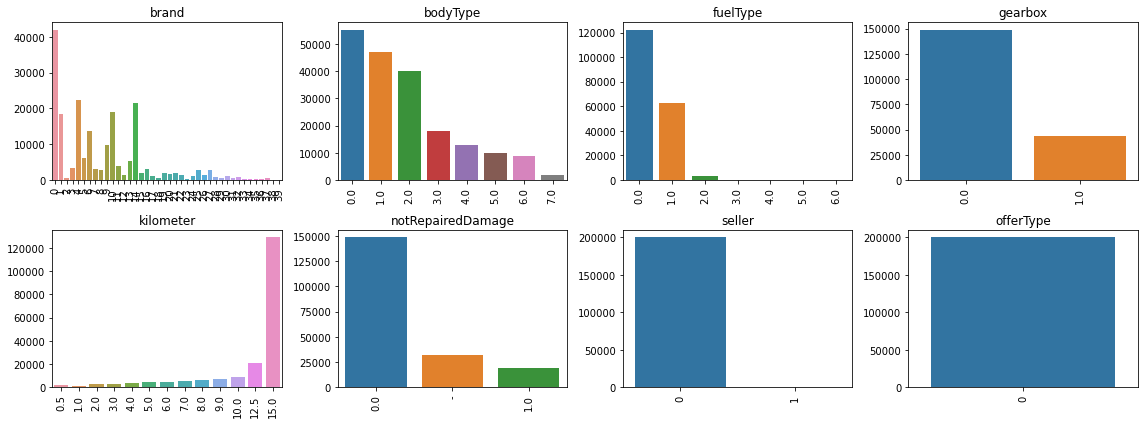

In [236]:
#类别特征取值较少的，画出直方图,
#'notRepairedDamage'存在无效字符，'seller,offerType'数值分布极不平衡
plt.figure()
plt.figure(figsize=(16, 6))
i = 1
for fea in cat_fea:
    if df[fea].nunique()<50:
        plt.subplot(2, 4, i)
        i += 1
        v = df[fea].value_counts()
        fig = sns.barplot(x=v.index, y=v.values)
        for item in fig.get_xticklabels():
            item.set_rotation(90)
        plt.title(fea)
plt.tight_layout()
plt.show()

<Figure size 432x288 with 0 Axes>

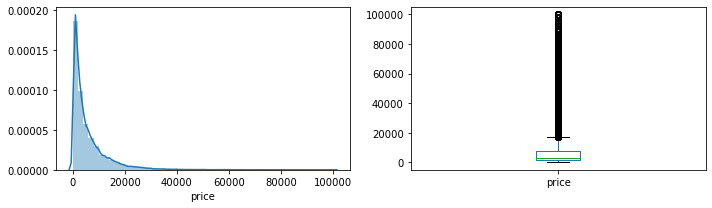

In [239]:
#'price'为长尾分布，需要做数据转换
plt.figure()
plt.figure(figsize=(10, 3))
plt.subplot(1, 2,1)
sns.distplot(train_data['price'])
plt.subplot(1,2,2)
train_data['price'].plot.box()
plt.tight_layout()

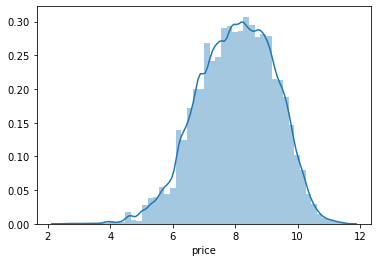

In [241]:
#'price'转化后的分布
plt.figure()
sns.distplot(np.log1p(train_data['price']))

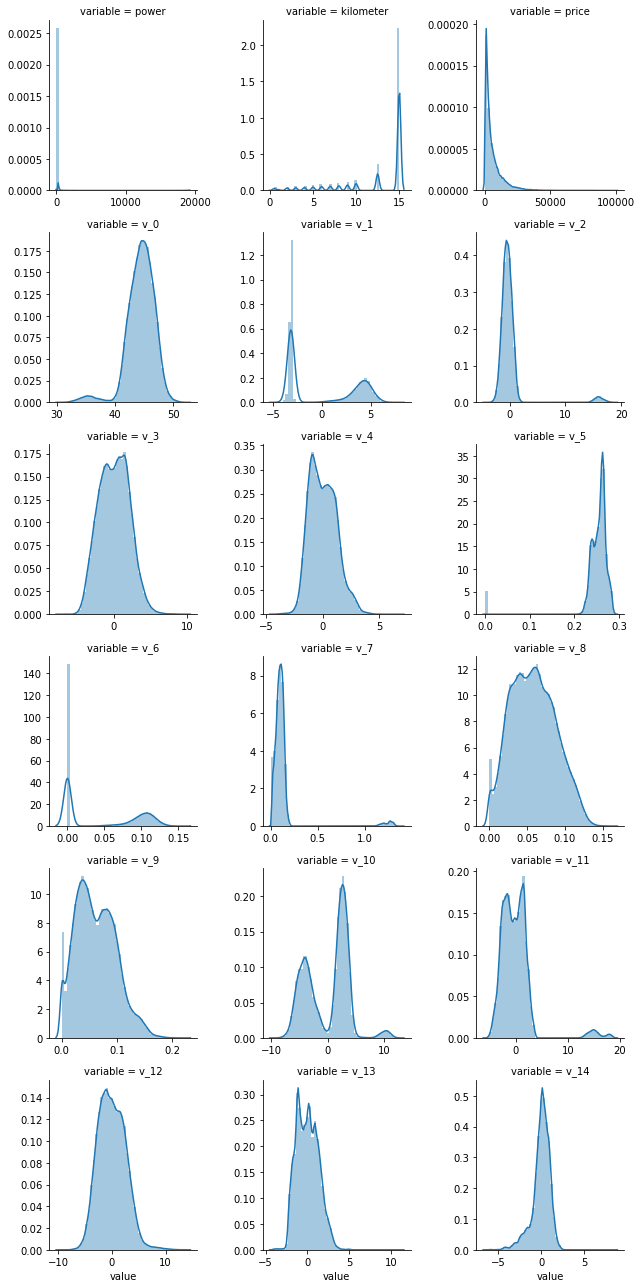

In [242]:
#数值特征分布，'power'的分布比较奇怪，后面做处理
num_fea = ['power', 'kilometer','price','v_0', 'v_1', 'v_2', 'v_3',
       'v_4', 'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12',
       'v_13', 'v_14']

f = pd.melt(train_data, value_vars=num_fea)
g = sns.FacetGrid(f, col="variable",  col_wrap=3, sharex=False, sharey=False)
g = g.map(sns.distplot, "value")

<Figure size 432x288 with 0 Axes>

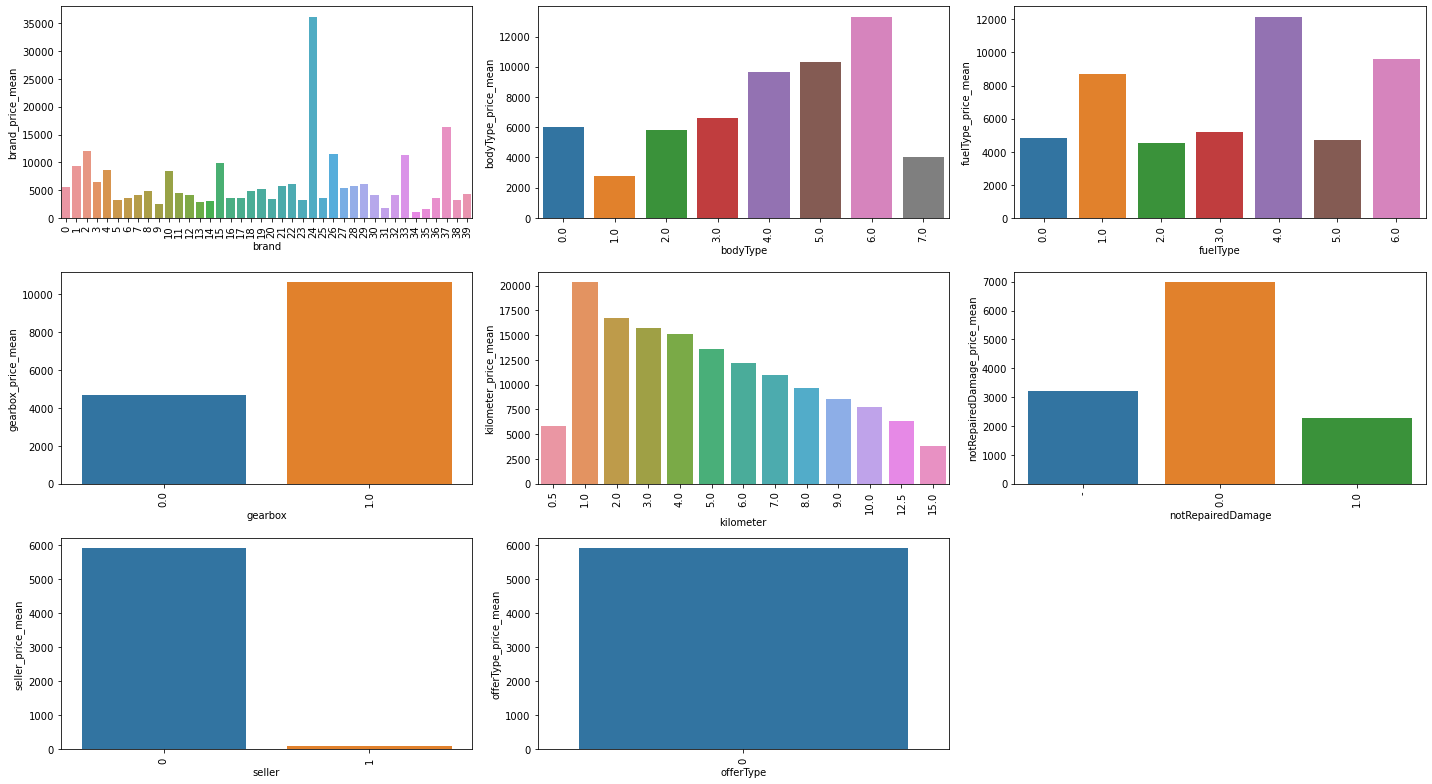

In [243]:
#选取类别特征取值较少的，观察它们与价格的均值分布，其中'kilometer'对价格的影响很明显
plt.figure()
plt.figure(figsize=(20, 18))
i = 1
for f in cat_fea:
    if df[f].nunique() <= 50:
        plt.subplot(5, 3, i)
        i += 1
        v = df[~df['price'].isnull()].groupby(f,as_index=False)['price'].agg({f + '_price_mean': 'mean'}).reset_index()
        fig = sns.barplot(x=f, y=f + '_price_mean', data=v)
        for item in fig.get_xticklabels():
            item.set_rotation(90)
plt.tight_layout()
plt.show()

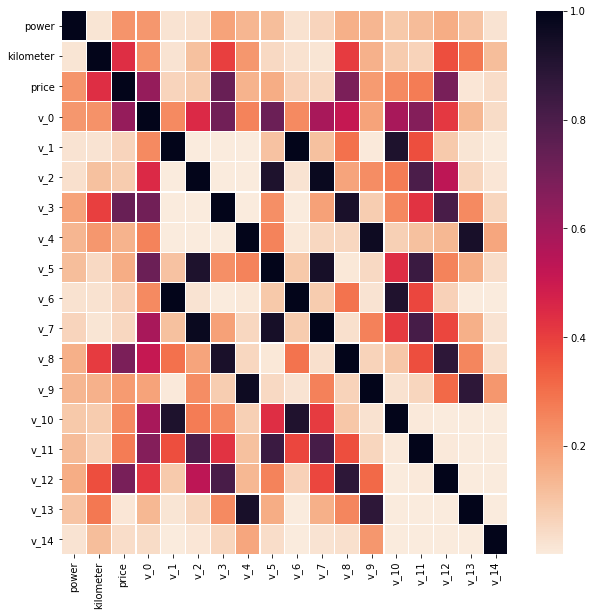

In [244]:
#匿名特征v_0,v_3,v_8,v_12与'price'相关性很高
corr1 = abs(df[df['price'].notnull()][num_fea].corr())
plt.figure(figsize=(10, 10))
sns.heatmap(corr1, linewidths=0.1, cmap=sns.cm.rocket_r)

## 查看数据缺失值

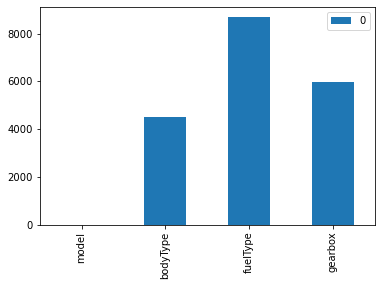

In [245]:

temp= train_data.isnull().sum()
temp = pd.DataFrame(temp)
temp= temp[temp[0]>0]
temp
temp.plot.bar()

## 数据报告生成

In [246]:

# 数据报告
import pandas_profiling as pp
report = pp.ProfileReport(train_data)


In [ ]:
%%time
report.to_file('report.html')

## 根据数据报告特征处理

### 缺失值处理

In [247]:
# 缺失值 model bodyType fuelType gearbox 填充众数
df['model'] = df['fuelType'].fillna(0)
df['bodyType'] = df['fuelType'].fillna(0)
df['fuelType'] = df['fuelType'].fillna(0)
df['gearbox'] = df['fuelType'].fillna(0)



In [248]:
# 赛题限定 power<=600
df['power'] = df['power'].map(lambda x: 600 if x>600 else x)


df['notRepairedDamage'].replace('-','0.0',inplace = True)
df['notRepairedDamage'] = df['notRepairedDamage'].astype('float32')

In [249]:
# 对可分类的连续特征进行分桶，kilometer是已经分桶了
bin = [i*10 for i in range(31)]
df['power_bin'] = pd.cut(df['power'], bin, labels=False)

bin = [i*10 for i in range(24)]
df['model_bin'] = pd.cut(df['model'], bin, labels=False)

## 日期类型处理

In [250]:
# 日期类型转换
#时间提取出年，月，日和使用时间
from datetime import datetime
def date_process(x):
    year = int(str(x)[:4])
    month = int(str(x)[4:6])
    day = int(str(x)[6:8])

    if month < 1:
        month = 1

    date = datetime(year, month, day)
    return date

df['regDate'] = df['regDate'].apply(date_process)
df['creatDate'] = df['creatDate'].apply(date_process)


In [251]:
# 时间多尺度 分成年月日
df['regDate_year'] = df['regDate'].dt.year
df['regDate_month'] = df['regDate'].dt.month
df['regDate_day'] = df['regDate'].dt.day

df['creatDate_year'] = df['creatDate'].dt.year
df['creatDate_month'] = df['creatDate'].dt.month
df['creatDate_day'] = df['creatDate'].dt.day


In [252]:
# 二手车使用天数
df['car_age_day'] = (df['creatDate'] - df['regDate']).dt.days

# 二手车使用年数
df['car_age_year'] = round(df['car_age_day'] / 365, 1)


类别特征'model', 'brand', 'bodyType', 'fuelType','gearbox', 'kilometer', 'notRepairedDamage', 'regionCode'和
数值特征'price','power','car_age_day'的交叉统计 只保留了部分有效组合

In [253]:
#类别特征对价格的统计最大，最小，平均值等等
cat_cols = ['brand','model','kilometer','fuelType','bodyType']
for col in cat_cols:
    t = train_data.groupby(col,as_index=False)['price'].agg(
        {col+'_count':'count',col+'_price_max':'max',col+'_price_median':'median',
         col+'_price_min':'min',col+'_price_sum':'sum',col+'_price_std':'std',col+'_price_mean':'mean'})
    df = pd.merge(df,t,on=col,how='left')

#行驶路程与功率统计
kk = ['kilometer','power']
t1 = train_data.groupby(kk[0],as_index=False)[kk[1]].agg(
        {kk[0]+'_'+kk[1]+'_count':'count',kk[0]+'_'+kk[1]+'_max':'max',kk[0]+'_'+kk[1]+'_median':'median',
         kk[0]+'_'+kk[1]+'_min':'min',kk[0]+'_'+kk[1]+'_sum':'sum',kk[0]+'_'+kk[1]+'_std':'std',kk[0]+'_'+kk[1]+'_mean':'mean'})
df = pd.merge(df,t1,on=kk[0],how='left')

由前面数据探索的结果可知部分v_0,v_3,v_8,v_12与price的相关性很高，所以做一些简单组合

In [254]:
num_cols = [0,3,8,12]
for i in num_cols:
    for j in num_cols:
        df['new'+str(i)+'*'+str(j)]=df['v_'+str(i)]*df['v_'+str(j)]
        
for i in num_cols:
    for j in num_cols:
        df['new'+str(i)+'+'+str(j)]=df['v_'+str(i)]+df['v_'+str(j)]

for i in num_cols:
    for j in num_cols:
        df['new'+str(i)+'-'+str(j)]=df['v_'+str(i)]-df['v_'+str(j)]

for i in range(15):
    df['new'+str(i)+'*year']=df['v_'+str(i)] * df['car_age_year']

## 提取数值类型特征列名

In [256]:
# 提取特征列
#划分训练数据和测试数据
df1 = df.copy()
test = df1[df1['price'].isnull()]
X_train = df1[df1['price'].notnull()].drop(['SaleID','price','name','regDate','seller','creatDate','offerType'],axis=1)
Y_train = df1[df1['price'].notnull()]['price']
X_test = df1[df1['price'].isnull()].drop(['SaleID','price','name','regDate','seller','creatDate','offerType'],axis=1)


In [257]:
# 统计函数,统计某字段的特征
def show_status(data):
    print('最大值',np.max(data))
    print('最小值',np.min(data))
    # ptp = max-min
    print('区间范围',np.ptp(data))
    print('平均值',np.mean(data))
    print('std',np.std(data))
    print('var',np.var(data))
show_status(Y_train)

最大值 99999.0
最小值 11.0
区间范围 99988.0
平均值 5923.327333333334
std 7501.973469876438
var 56279605.94272992


# 模型训练与预测

## 利用xgb进行五折交叉验证查看模型的参数效果

In [151]:

from sklearn.model_selection import GridSearchCV,cross_val_score,StratifiedKFold,train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error


xgr = xgb.XGBRegressor(n_estimators=120, learning_rate=0.1, gamma=0, subsample=0.8,\
        colsample_bytree=0.9, max_depth=7) #,objective ='reg:squarederror'

scores_train = []
scores = []

## 5折交叉验证方式
sk=StratifiedKFold(n_splits=5,shuffle=True,random_state=0)
for train_ind,val_ind in sk.split(X_train,Y_train):
    
    train_x = X_train.iloc[train_ind].values
    train_y = Y_train.iloc[train_ind]
    val_x = X_train.iloc[val_ind].values
    val_y = Y_train.iloc[val_ind]
    
    xgr.fit(train_x,train_y)
    pred_train_xgb = xgr.predict(train_x)
    pred_xgb = xgr.predict(val_x)
    
    score_train = mean_absolute_error(train_y,pred_train_xgb)
    scores_train.append(score_train)
    score = mean_absolute_error(val_y,pred_xgb)
    scores.append(score)

print('Train mae:',np.mean(score_train))
print('Val mae',np.mean(scores))

Train mae: 512.4577371953498
Val mae 607.6731368796158


## 定义xgb和lgb模型函数

In [212]:
def build_model_xgb(x_train,y_train):
    model = xgb.XGBRegressor(max_depth=6, 
                             learning_rate=0.05, 
                             n_estimators=500, 
                             objective ='reg:linear', 
                             subsample=0.8, 
                             min_child_samples = 3,
                             eval_metric = 'auc', 
                             reg_lambda=0.5
                             ) 
    
    model.fit(x_train, y_train)
    return model

def build_model_lgb(x_train,y_train):
    estimator = lgb.LGBMRegressor(num_leaves=2**5-1,
                                  reg_alpha=0.25,
                                  reg_lambda=0.25,
                                  max_depth=-1,
                                  learning_rate=0.005,
                                  min_child_samples=3,
                                  random_state=2021,
                                  n_estimators = 500,
                                 subsample=1,
                                 colsample_bytree = 1)
    param_grid = {
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
    }
    gbm = GridSearchCV(estimator, param_grid)
    gbm.fit(x_train, y_train)
    return gbm

## 切分数据集（Train,Val）进行模型训练，评价和预测

In [193]:
x_train,x_val,y_train,y_val = train_test_split(X_train,Y_train,test_size=0.3)

In [ ]:
print('Train lgb...')
model_lgb = build_model_lgb(x_train,y_train)
val_lgb = model_lgb.predict(x_val)
MAE_lgb = mean_absolute_error(y_val,val_lgb)
print('MAE of val with lgb:',MAE_lgb)

print('Predict lgb...')
model_lgb_pre = build_model_lgb(X_train,Y_train)
subA_lgb = model_lgb_pre.predict(X_test)
print('Sta of Predict lgb:')
show_status(subA_lgb)

In [ ]:
print('Train xgb...')
model_xgb = build_model_xgb(x_train,y_train)
val_xgb = model_xgb.predict(x_val)
MAE_xgb = mean_absolute_error(y_val,val_xgb)
print('MAE of val with xgb:',MAE_xgb)

print('Predict xgb...')
model_xgb_pre = build_model_xgb(X_train,Y_train)
subA_xgb = model_xgb_pre.predict(X_test)
print('Sta of Predict xgb:')
show_status(subA_xgb)

## 进行两模型的结果加权融合

In [216]:
subA_xgb

array([1328.5223, 1907.5767, 8335.677 , ..., 5359.319 , 4810.727 ,
       5211.9263], dtype=float32)

In [223]:
subA_lgb

array([1322.15764265, 1881.38606179, 8488.88798636, ..., 5429.17964803,
       4775.20054686, 5367.12458338])

In [ ]:
## 简单的加权融合的方式
val_Weighted = (1-MAE_lgb/(MAE_xgb+MAE_lgb))*val_lgb+(1-MAE_xgb/(MAE_xgb+MAE_lgb))*val_xgb
print('MAE of val with Weighted ensemble:',mean_absolute_error(y_val,val_Weighted))



In [219]:
sub_Weighted = (1-MAE_lgb/(MAE_xgb+MAE_lgb))*subA_lgb+(1-MAE_xgb/(MAE_xgb+MAE_lgb))*subA_xgb
sub_Weighted

array([1325.32684671, 1894.42740807, 8412.59776489, ..., 5394.39309079,
       4792.89052268, 5289.84494444])

## 生成报告

In [220]:
result = pd.DataFrame()
result['SaleID'] = test['SaleID']
result['price'] = sub_Weighted

# 由于我们发现预测的最小值有负数，而真实情况下，price为负是不存在的，所以改为最低价格
result[result['price']<0]=11 
result

SaleID         price
150000  200000   1325.326847
150001  200001   1894.427408
150002  200002   8412.597765
150003  200003   1229.394691
150004  200004   2002.751064
...        ...           ...
199995  249995   6440.650770
199996  249996  18456.487024
199997  249997   5394.393091
199998  249998   4792.890523
199999  249999   5289.844944

[50000 rows x 2 columns]

In [222]:
result.to_csv('basline_xgb_lgb.csv', index = False)